In [1]:
import pysam
import pandas as pd
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading the file and appying transformations

In [2]:
sam_path = "data/rd/SRR.sam"

In [3]:
len_chr={}
with open(sam_path, 'r') as f:
    for line in f:
        l = line.replace('\n', '').split('\t')
        sn = l[1].replace('SN:', '')
        ln = l[2].replace('LN:', '')
        len_chr[sn] = ln
        if line[:1] == '@':
            pass
        else:
            break

In [4]:
SF = pysam.Samfile(sam_path, "rb")

## Creation of dataframe with genome information

In [5]:
sam_list = []
for sam in SF.fetch():
    sam_list.append([SF.getrname(sam.rname), sam.qname, sam.flag, sam.pos, sam.cigar, sam.seq])
    
SF.close()

df_sam = pd.DataFrame(sam_list, columns=['rname', 'qname', 'flag', 'pos', 'cigar', 'seq'])
df_sam['ln'] = df_sam['rname'].apply(lambda x: len_chr[x] if x in len_chr else np.nan)
df_sam = df_sam[df_sam['ln'].notna()]

df_sam['ln'] = df_sam['ln'].astype(int)

## Processing the SAM file

In [6]:
# Generate unsorted BAM file
pysam.samtools.view("-b", f"-odata/rd/SRR_unsorted.bam", sam_path, catch_stdout=False)

In [7]:
pysam.sort("data/rd/SRR_unsorted.bam", "-o", "data/rd/SRR.bam");

In [8]:
# Generate index for BAM file
pysam.index("data/rd/SRR.bam");

In [6]:
BF = pysam.AlignmentFile("data/rd/SRR.bam", "rb")

## Getting the number of reads for rach position

In [7]:
signal = np.zeros(df_sam['pos'].max()) 

for pos in BF.pileup():
    signal[pos.reference_pos] = pos.n

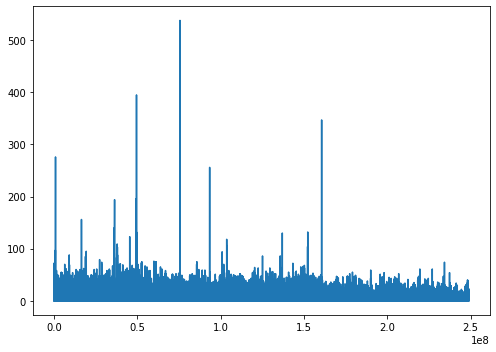

In [8]:
plt.figure(figsize=(7,5))
plt.plot(signal)
plt.tight_layout()
plt.show()

### Averaging over 100bp

In [9]:
sig_ln = signal.shape[0]

signal_avg_100 = signal[:sig_ln-sig_ln%100].reshape(-1, 100).mean(1)

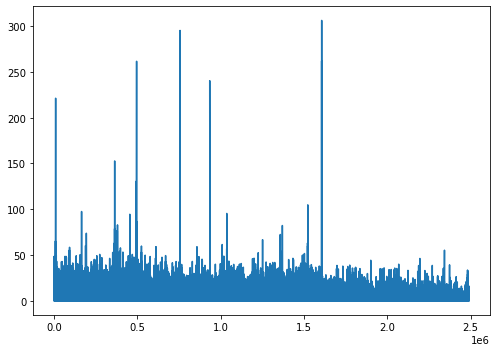

In [10]:
plt.figure(figsize=(7,5))
plt.plot(signal_avg_100)
plt.tight_layout()
plt.savefig('bined_signal.png', bbox_inches='tight')

### Creationf of hist of AVG RD

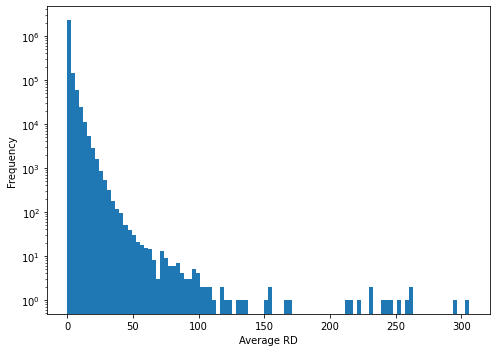

In [11]:
plt.figure(figsize=(7,5))
plt.hist(signal_avg_100, 100)
plt.yscale('log')
plt.xlabel('Average RD')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('hist_signal.png', bbox_inches='tight')

In [12]:
# plt.plot(signal_avg_100[:-1] - signal_avg_100[1:], signal_avg_100[1:] - signal_avg_100[:-1], '.')
# plt.show()

## AVG over 5k

In [13]:
signal_avg_5k = signal[:sig_ln-sig_ln%(5*10**5)].reshape(-1, 5*10**5).mean(1)

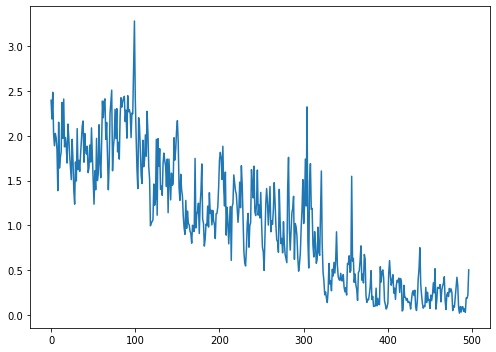

In [15]:
plt.figure(figsize=(7,5))
plt.plot(signal_avg_5k)
plt.tight_layout()
plt.savefig('bined_signal_5k.png', bbox_inches='tight')

## Deciding to use only chr1

In [16]:
signal_ch = np.zeros(df_sam[df_sam['rname']=='chr1']['pos'].max()) 

for pos in BF.pileup('chr1'):
    signal_ch[pos.reference_pos] = pos.n

In [17]:
# plt.figure(figsize=(7,5))
# plt.plot(signal_ch)
# plt.tight_layout()

In [18]:
signal_ch_avg_5k = signal_ch[:sig_ln-sig_ln%(5*10**4)].reshape(-1, 5*10**4).mean(1)

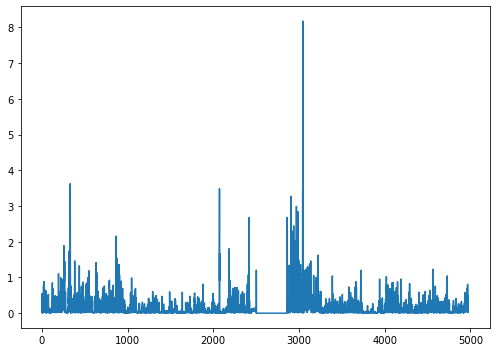

In [23]:
# seeing centromere
plt.figure(figsize=(7,5))
plt.plot(signal_ch_avg_5k)
plt.tight_layout()
plt.savefig('bined_signal_5k.png', bbox_inches='tight')

In [24]:
signal_ch.shape

(248946118,)

## GC correction

In [25]:
gc_reads = []
for i in tqdm(range(signal_ch_avg_5k.shape[0])):
    total_bases = 0
    gc_bases = 0
    read_data = BF.fetch('chr1', i*(5*10**4), (i+1)*(5*10**4) )
    for read in read_data:
        seq = read.query_sequence
        total_bases += len(seq)
        gc_bases += len([x for x in seq if x == 'C' or x == 'G'])
    if total_bases == 0:
        gc_percent = 0
    else:
        gc_percent = gc_bases#/total_bases * 100
    gc_reads.append(gc_percent)

100%|█████████████████████████████████████| 4978/4978 [00:02<00:00, 1746.65it/s]


In [26]:
gc_reads = np.array(gc_reads)

In [27]:
RD_global = np.mean( signal_ch_avg_5k ) 

In [28]:
signal_GC_corr = np.zeros(shape=signal_ch_avg_5k.shape)

In [29]:
for RD_raw, gc, j in zip(signal_ch_avg_5k, gc_reads, range(signal_ch_avg_5k.shape[0])):
    RD_gc = np.mean( signal_ch_avg_5k[gc_reads==gc] )
    if RD_gc == 0:
        signal_GC_corr[j] = 0
    else:
        signal_GC_corr[j] = RD_global / RD_gc * RD_raw

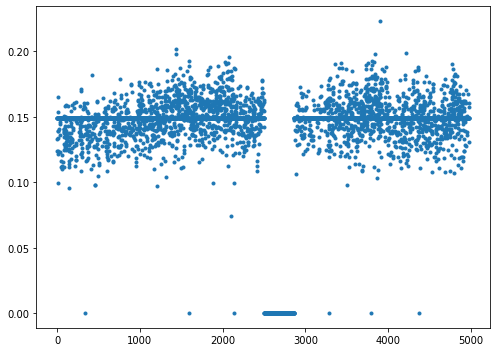

In [33]:
# seeing centromere
plt.figure(figsize=(7,5))
plt.plot(signal_GC_corr, '.')
plt.tight_layout()
plt.savefig('GC_correction_5k.png', bbox_inches='tight')

## Normalisation of data

In [35]:
signal_norm = ( signal_GC_corr - np.mean( signal_GC_corr) ) / np.std(signal_GC_corr)

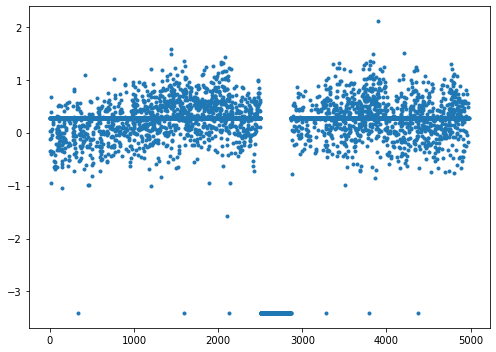

In [36]:
# seeing centromere
plt.figure(figsize=(7,5))
plt.plot(signal_norm, '.')
plt.tight_layout()
plt.savefig('signal_norm_5k.png', bbox_inches='tight')

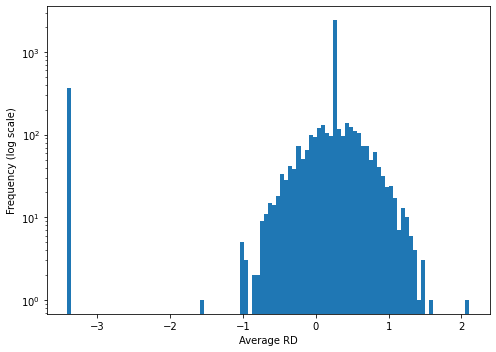

In [46]:
plt.figure(figsize=(7,5))
plt.hist(signal_norm, 100)
plt.yscale('log')
plt.xlabel('Average RD')
plt.ylabel('Frequency (log scale)')
plt.tight_layout()
plt.savefig('hist_signal_norm.png', bbox_inches='tight')

In [38]:
# plt.figure(figsize=(7,5))
# plt.hist(signal_ch_avg_5k, 100)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Average RD')
# plt.ylabel('Frequency')
# plt.tight_layout()

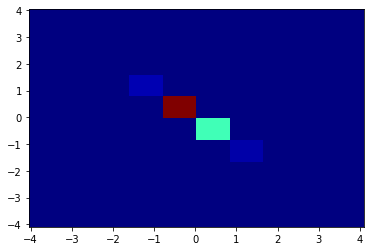

In [41]:
x = signal_norm[:-1] - signal_norm[1:]
y = signal_norm[1:] - signal_norm[:-1]

# Big bins
plt.hist2d(x, y, bins=(10, 10), cmap=plt.cm.jet)
plt.show()

# Closing bam file

In [42]:
BF.close()

# Straightforward approach - trying to visualize the RD
(not very efficient)

In [ ]:
df_chr = df_sam[df_sam['rname']=='chrY']

max_gene = df_chr['pos'].max() + df_chr['ln'].max()

chr_genom_reads = np.zeros(shape=(max_gene,) )

for pos, ln in tqdm(zip(
        df_chr['pos'].values, 
        df_chr['ln'].values),
            total=df_chr.shape[0], position=0, leave=True):
    
    chr_genom_reads[pos:pos+ln] += 1
    
chr_ln = chr_genom_reads.shape[0]

chr_avg_100 = chr_genom_reads[:chr_ln-chr_ln%100].reshape(-1, 100).mean(1)

In [ ]:
plt.step( range(chr_avg_100.shape[0]), chr_avg_100)
plt.show()